In [1]:
import trainHelper
import utils
from mds.lmds import landmarkMDS
from mds.cmds import classicalMDS
from mds.fastmap import fastmap
import numpy
from torch.utils.data import DataLoader
import torch
from torch import nn, Tensor
import lossFunction as lossF
from model.AutoEncoder import AutoEncoder
from model.DynParam import DynParam
from model.Linear import Linear
from model.VAE import VAE
import os.path

In [24]:
import sys
from importlib import reload
reload(sys.modules['utils'])
reload(sys.modules['trainHelper'])
reload(sys.modules['lossFunction'])

<module 'lossFunction' from 'e:\\CityU\\FYP\\lossFunction.py'>

In [3]:
torch.set_default_tensor_type('torch.DoubleTensor')


In [4]:

sample_space = (1000000, 100)
ss, N, d = 800, 20, 2

try:
    euclidean_data = utils.load_variable('data/euclidean_data.pkl')
    rand_data = utils.load_variable('data/rand_data.pkl')

    if euclidean_data.size() != (ss, 1, N, N):
        print("Updated data for requirement !")
        raise Exception("Previous data not match requirement !")

except:
    euclidean_data = utils.generate_euclidean_DM(
        N=N, d=d,
        sample_size=ss,
        sample_space=sample_space, isInt=True)

    rand_data = utils.generate_rand_DM(
        N=N,
        sample_size=ss,
        sample_space=sample_space, isInt=True)

    utils.dump_variable(euclidean_data, 'data/euclidean_data.pkl')
    utils.dump_variable(rand_data, 'data/rand_data.pkl')

In [5]:
data = torch.stack([
            euclidean_data.view(ss, 1, N*N),
            rand_data.view(ss, 1, N*N)
        ]).view(ss * 2, 1, N * N)

data = torch.tensor(data.data, requires_grad=True)

In [6]:
target_dim = 2

model = Linear([N * N, 32, 32, N * target_dim], final_activation=None)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

lossFun = lossF.CoordsToDMLoss(
    target_dim=(N, target_dim),
    lossFun=nn.MSELoss(reduction='sum'))

helper = trainHelper.TrainHelper(
    id="Linear_with_two_32_layers",
    model=model,
    optimizer=optimizer,
    lossFun=lossFun,
    lr_factor=0.1)

In [7]:
batch = 32
dlr = DataLoader(data, batch_size=batch, shuffle=True)

In [8]:
EPOCH = 10
print_on_each = 5

time_used = utils.time_measure(helper.train, 
                    [dlr, EPOCH, print_on_each])[1]

print("Time used for the training: ", time_used, "s")

helper.backup()

0 	| Mean loss: 1275.8987239771761
5 	| Mean loss: 1172.833758286423
Time used for the training:  145.893362 s


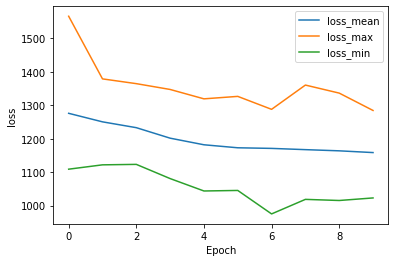

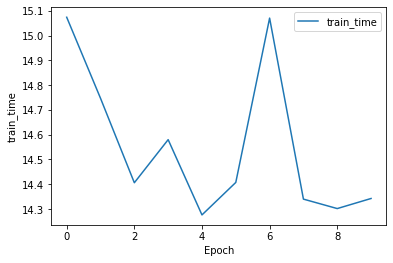

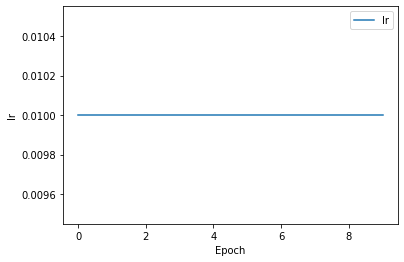

In [9]:
helper.plot(['loss_mean', 'loss_max', 'loss_min'], value_label='loss')
helper.plot(['train_time'], value_label='train_time')
helper.plot(['lr'], value_label='lr')

In [42]:
test_data = utils.generate_euclidean_DM(
    N=N, d=2,
    sample_size=200,
    sample_space=sample_space, isInt=True)


In [47]:

cmds_loss, fastmap_loss, model_loss = [], [], []

with torch.no_grad():

    for d in test_data:

        d1 = numpy.array(d[0].data)

        cmds_rs = classicalMDS(d1, 2)
        cmds_rs = torch.tensor(cmds_rs)
        cmds_dm, _ = utils.get_distance_matrix(cmds_rs)
        cmds_loss.append(torch.sum((cmds_dm - d)** 2))

        fastmap_rs = fastmap(d1, 2)
        fastmap_rs = torch.tensor(fastmap_rs)
        fastmap_dm, _ = utils.get_distance_matrix(fastmap_rs)
        fastmap_loss.append(torch.sum((fastmap_dm - d)** 2))

        d2 = d.view(1, 1, N * N)

        model_rs = model(d2).view(N, 2)
        model_dm, _ = utils.get_distance_matrix(model_rs)
        model_loss.append(torch.sum((model_dm - d) ** 2))
        
    print("cmds_loss: \t", torch.tensor(cmds_loss).mean())
    print("fastmap_loss: \t", torch.tensor(fastmap_loss).mean())
    print("model_loss: \t", torch.tensor(model_loss).mean())    


cmds_loss: 	 tensor(1.1743e-28)
fastmap_loss: 	 tensor(14.9572)
model_loss: 	 tensor(27.0287)


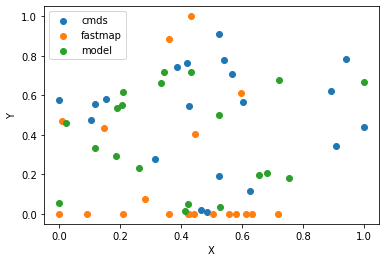

In [44]:
cmds_rs = utils.minmax_norm(cmds_rs, (1, N * 2))[0]
fastmap_rs = utils.minmax_norm(fastmap_rs, (1, N * 2))[0]
model_rs = utils.minmax_norm(model_rs, (1, N * 2))[0]

utils.plot_2D_coords(
    {
        'cmds': cmds_rs,
        'fastmap': fastmap_rs,
        'model': model_rs
    }
)